In [1]:
import tensorflow as tf
import os
import zipfile
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dense, Embedding, Bidirectional, LSTM, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax, SGD, Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, Xception, InceptionV3, ResNet50, EfficientNetB4, InceptionResNetV2
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



print(tf.__version__)



2.8.0


## 🧹 Dataset Preparation

The dataset used in this project was composed of two separate CSV files, each with a different internal structure.  
To unify the data and prepare it for training, both files were read and processed using different approaches depending on their format.

- One CSV file had a **structured format** with two labeled columns: `comentario (comment in English)` and `sentimiento (sentiment in English)`.
- The second file required **manual parsing**, reading line by line and applying cleaning steps to extract usable comments.

After processing, all the data was merged and loaded into a single **Pandas DataFrame** for further preprocessing and model training.

In [2]:
df1 = pd.read_csv("Comentarios2.csv", encoding="latin-1")

In [3]:
df1.head()

,comentario,sentimiento
0,Este producto me encantó,positivo
1,No cumplió lo que prometía,negativo
2,Me parece algo normal,neutro
3,Repetiría la compra sin dudarlo,positivo
4,El servicio fue pésimo,negativo


In [4]:
import pandas as pd

with open("Comentarios1.csv", "r", encoding="latin-1") as file:
    comments = [line.strip() for line in file if line.strip()]


for i in range(len(comments)):
    if '"' in comments[i]:
        comments[i] = comments[i].replace('""', "")
    comments[i] = comments[i].strip()

lista_comentarios = []
lista_sentimientos = []

for linea in comments:
    partes = linea.split(":")
    
    if len(partes) < 2:
        print("Línea con formato inesperado:", linea)
        continue

    comentario = partes[0].strip()
    sentimiento = partes[1].strip()

    lista_comentarios.append(comentario)
    lista_sentimientos.append(sentimiento)


df2 = pd.DataFrame()
df2["comentario"] = lista_comentarios
df2["sentimiento"] = lista_sentimientos
df2.sentimiento = df2.sentimiento.apply(lambda x : x.replace('"', "").strip())
df2.comentario = df2.comentario.apply(lambda x : x.replace('"', "").strip())
df2.head(100
)


,comentario,sentimiento
0,"Me encantó la rapidez de envío, llegó antes de...",positivo
1,"La calidad del producto es buena, pero el prec...",neutro
2,"No recomendaría este servicio, me ha dado much...",negativo
3,"La atención al cliente fue excelente, resolvie...",positivo
4,"El producto cumple su función, pero no supera ...",neutro
...,...,...
95,El producto me llegó usado y con signos de des...,negativo
96,"La oferta no se ve mal, pero no incluye envío ...",neutro
97,Compré dos unidades y ambas funcionan de marav...,positivo
98,"Tras varios intentos, sigue sin reconocer mi c...",negativo


In [5]:
df= pd.concat([df1, df2], ignore_index = True)

## 📊 Sentiment Distribution Analysis

To ensure that the dataset is **balanced** across the three sentiment classes (*positive*, *neutral*, *negative*), we visualized the distribution of samples using two types of charts:

- A **bar chart** to clearly compare the number of samples per class.
- A **pie chart** to show the percentage representation of each sentiment.

These visualizations confirmed that the dataset is well-balanced, which is important to help the model generalize properly and avoid bias toward any particular class.

In [6]:
df.describe(include = "all")

,comentario,sentimiento
count,2344,2344
unique,2007,3
top,Este producto me encantó,positivo
freq,10,820


In [7]:
sentimientos = df.sentimiento.unique()

([<matplotlib.patches.Wedge at 0x28857068190>,
 [Text(0.4999149384041554, 0.9798393002734529, 'positivo'),
  Text(-1.093200842588509, -0.12211436346218435, 'negativo'),
  Text(0.6055998948492084, -0.9182857765198305, 'neutro')],
 [Text(0.27268087549317566, 0.534457800149156, '34.98%'),
  Text(-0.5962913686846412, -0.06660783461573691, '33.58%'),
  Text(0.3303272153722954, -0.5008831508289984, '31.44%')])

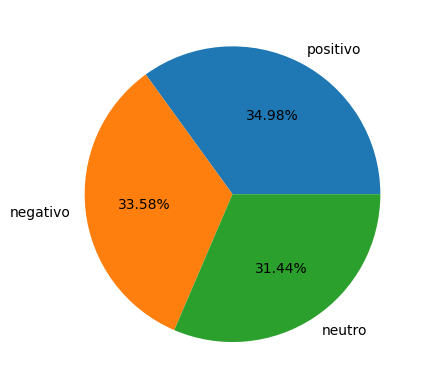

In [8]:
plt.pie(df.sentimiento.value_counts().values, labels=sentimientos, autopct="%1.2f%%")

In [9]:
count_sentiments = df.groupby(["sentimiento"]).size().reset_index().rename(columns={0:"Sentiment Count"})
count_sentiments.head()

,sentimiento,Sentiment Count
0,negativo,787
1,neutro,737
2,positivo,820


<AxesSubplot:xlabel='sentimiento', ylabel='Sentiment Count'>

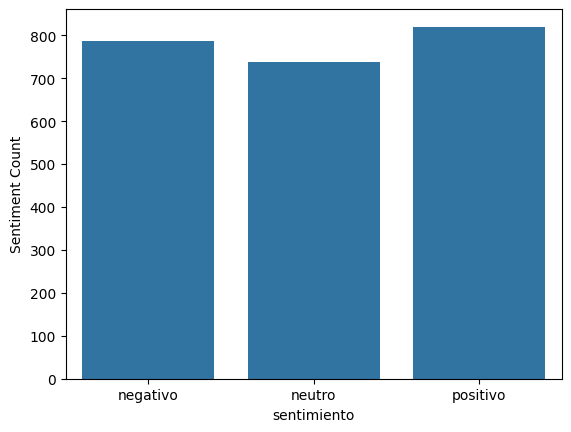

In [10]:
sns.barplot(data = count_sentiments, x = "sentimiento", y = "Sentiment Count")

## 📊 Why This Split Matters

It is very important that the **training set** represents the largest portion of the dataset, because this is the data the model actually learns from.

The **validation set** is used during training to monitor how well the model is generalizing. It helps us detect problems like overfitting and adjust hyperparameters accordingly.

Finally, the **test set** is used only once at the end of the training process — it gives us an unbiased estimate of the model’s real-world performance on unseen data.

This split ensures that we can properly train, fine-tune, and evaluate our model with confidence.

In [11]:
#Dividir el conjunto de datos(train, validation, test)
from sklearn.model_selection import train_test_split

train_validation, test_df = train_test_split(df, test_size = 0.10, random_state = 42)
train_df, validation_df = train_test_split(train_validation, test_size = 0.15/(1-0.10), random_state = 42)

train_df = train_df.reset_index()
validation_df = validation_df.reset_index()
test_df = test_df.reset_index()


In [12]:
print("TOTAL TRAIN:",train_df.shape[0])
print("TOTAL VALIDATION:",validation_df.shape[0])
print("TOTAL TEST:",test_df.shape[0])

TOTAL TRAIN: 1757
TOTAL VALIDATION: 352
TOTAL TEST: 235


In [13]:
train_df.drop(columns = "index", inplace = True)
validation_df.drop(columns = "index", inplace = True)
test_df.drop(columns = "index", inplace = True)

In [14]:
train_df.head()

,comentario,sentimiento
0,"No recomiendo este servicio, el personal no ti...",negativo
1,"No me impactó mucho, se nota que es un product...",neutro
2,La velocidad de carga del servicio supera la d...,positivo
3,Una experiencia destacable,positivo
4,Es adecuado para su precio,neutro


## 🧾 One-Hot Encoding of Sentiment Labels

Since machine learning models cannot understand text labels directly, we apply **one-hot encoding** to convert the sentiment labels into a numerical format.

This technique transforms each sentiment category (e.g., `positive`, `neutral`, `negative`) into a vector of binary values that the model can understand.

For example:
- `positive` → `[0, 0, 1]`
- `neutral` → `[0, 1, 0]`
- `negative` → `[1, 0, 0]`

This step is essential for multi-class classification problems, as it allows the model to output probabilities for each class using functions like `softmax`.

In [15]:
#Codificación One-Hot de los conjuntos de entrenamiento/validación/prueba
train_df = pd.get_dummies(train_df, columns=["sentimiento"])
validation_df = pd.get_dummies(validation_df, columns=["sentimiento"])
test_df = pd.get_dummies(test_df, columns=["sentimiento"])


In [16]:
train_df.columns

Index(['comentario', 'sentimiento_negativo', 'sentimiento_neutro',
       'sentimiento_positivo'],
      dtype='object')

In [17]:
test_df.head()

,comentario,sentimiento_negativo,sentimiento_neutro,sentimiento_positivo
0,La atención del personal fue impecable y muy a...,False,False,True
1,La comida era aceptable sin nada especial,False,True,False
2,Me agradó la rapidez con la que se procesó el ...,False,False,True
3,Superó mis expectativas en cuanto a durabilidad,False,False,True
4,El producto defectuoso no fue reemplazado a pe...,True,False,False


In [18]:
test_df[["sentimiento_negativo", 
                  "sentimiento_positivo", 
                  "sentimiento_neutro"]].values

array([[False,  True, False],
       [False, False,  True],
       [False,  True, False],
       [False,  True, False],
       [ True, False, False],
       [ True, False, False],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [ True, False, False],
       [ True, False, False],
       [False, False,  True],
       [False,  True, False],
       [ True, False, False],
       [False,  True, False],
       [ True, False, False],
       [False,  True, False],
       [False, False,  True],
       [False,  True, False],
       [ True, False, False],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False,  True, False],
       [False,  True, False],
       [False,  True, False],
       [ True, False, False],
       [False,  True, False],
       [False,  True, False],
       [ True, False, False],
       [False,  True, False],
       [ True, False, False],
       [ T

In [19]:
y_train = train_df[["sentimiento_negativo", 
                    "sentimiento_neutro", 
                    "sentimiento_positivo"]].values
y_val = validation_df[["sentimiento_negativo", 
                       "sentimiento_neutro", 
                       "sentimiento_positivo"]].values
y_test = test_df[["sentimiento_negativo", 
                  "sentimiento_neutro", 
                  "sentimiento_positivo"]].values


## 🔡 Text Tokenization and Padding

Before feeding the text data into the neural network, we need to convert it into a numerical format that the model can understand.

1. We use a `Tokenizer` to build a vocabulary of the **5000 most frequent words** in the training set.  
   Each word is assigned a unique integer index, forming a dictionary.

2. The comments are then converted into sequences of integers, where each integer represents a word.  
   Words not in the top 5000 are replaced with a special token (`<OOV>`, Out-Of-Vocabulary).

3. Finally, we apply **padding** to ensure that all sequences have the same length (`maxlen = 50`).  
   This allows the input to be processed in batches and ensures consistency across training samples.

This step is essential in NLP tasks to transform raw text into a **numerical** structured, model-ready format. **(Remember, the model only understands number!)**


In [20]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df["comentario"])

train_sequences = tokenizer.texts_to_sequences(train_df["comentario"])
val_sequences = tokenizer.texts_to_sequences(validation_df["comentario"])
test_sequences = tokenizer.texts_to_sequences(test_df["comentario"])

max_length = 50
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')


In [21]:
X_train = train_padded
X_val = val_padded
X_test = test_padded


In [22]:
train_padded

array([[   5,  101,   42, ...,    0,    0,    0],
       [   5,    9, 1084, ...,    0,    0,    0],
       [   3,  131,    4, ...,    0,    0,    0],
       ...,
       [ 141, 1983,   20, ...,    0,    0,    0],
       [   3,  139,   19, ...,    0,    0,    0],
       [  15,  503,   10, ...,    0,    0,    0]])

## 💾 Saving the Tokenizer

We save the `Tokenizer` object using Python's `pickle` module.

This is very important because we'll need to use the **same tokenizer** later when we deploy the model in our Flask web app. If we used a new tokenizer, it could assign different indices to the words, leading to incorrect predictions.


In [23]:
import pickle

with open("modeltokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [24]:
vocab_size = 5000          
embedding_dim = 128        
max_length = 50            


## 🧠 Model Definition

The model is built using the **Sequential API** from Keras and consists of the following layers:

1. **Embedding Layer**
   - Transforms each word index into a dense vector of fixed size.
   - Helps the model learn relationships between words during training.
   - Required because neural networks cannot understand raw integer indices.
   - Defined as:  
     ```python
     Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)
     ```

2. **Bidirectional LSTM Layer**
   - A Long Short-Term Memory (LSTM) layer that reads sequences in **both directions** (forward and backward).
   - This allows the model to understand context from both past and future words.
   - We use `return_sequences=False` to get a single output vector per comment.

3. **Dropout Layer**
   - Randomly disables 50% of neurons during training to prevent overfitting.
   - Helps the model generalize better, especially with small datasets.

4. **Dense Output Layer**
   - Has 3 units (one for each sentiment class: positive, neutral, negative).
   - Uses a **softmax** activation to output class probabilities.

5. **Compilation**
   - Optimizer: `adam`, for efficient and adaptive learning.
   - Loss: `categorical_crossentropy`, because we're using **one-hot encoded** labels.
   - Metric: `accuracy` to evaluate how often the model predicts the correct class.

### 💡 Summary
This architecture is designed for **multi-class text classification** and balances simplicity with performance. It includes essential layers for understanding text data, avoiding overfitting, and producing accurate class predictions.


## 🧠 How Does the Embedding Layer Learn Word Meaning?

At the beginning of training, the embedding layer assigns **random vectors** to each word.  
The model has no idea what words like *"happy"* or *"sad"* mean — it doesn't understand language like humans do.

However, during training, the model sees many examples like:

- "Estoy muy **feliz** con el producto" → `positive`
- "Estoy muy **alegre** con el servicio" → `positive`

Both *feliz* and *alegre* appear in **similar contexts** and lead to the **same sentiment label**.

Over time:
1. The model makes predictions, compares them with the actual labels, and calculates the **error (loss)**.
2. Using backpropagation, it updates all trainable weights — including the vectors in the embedding layer.
3. It learns that making the vectors for *feliz* and *alegre* more similar helps it reduce the error.
4. As a result, their embeddings become **closer** in the vector space.

This is how the model **learns the "meaning" of words through usage and context**, not by knowing their definitions.

> ⚠️ Words that appear rarely may not have reliable embeddings, which is why we limit the vocabulary size and use `<OOV>` tokens.


In [25]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))

model.add(Bidirectional(LSTM(64, return_sequences=False)))

model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 739,203
Trainable params: 739,203
Non-trainable params: 0
_________________________________________________________________


## 🏋️ Model Training Begins

We now begin training the model using the prepared training and validation data.

The number of epochs has been set to a relatively high value (e.g., 100).  
This allows us to observe how the model behaves over time and helps us detect when **overfitting** begins to occur.

By plotting the **training and validation accuracy/loss**, we can identify the point where the model stops improving on validation data while still improving on the training data. This is a typical sign of overfitting.

You can use callbacks to stop the training process when it strarts to overfit the model


## 🧪 Hyperparameter Tuning vs. Data Quantity

To improve the model’s performance, we could experiment with different **hyperparameters**, such as:

- `batch_size`
- `learning_rate`
- Number of LSTM units
- Dropout rate
- Optimizer choice
- Embedding dimensions

While adjusting these values may lead to better results, it's important to highlight that **one of the most critical factors in deep learning is the amount of training data**.

With limited data, the model can struggle to generalize well — even if hyperparameters are carefully tuned.  
A larger dataset provides more variety, reduces noise, and gives the model more context to learn meaningful patterns, especially in tasks involving language and sentiment.

> 🔑 **Conclusion**: Hyperparameter tuning is useful, but having **enough quality training data** is essential for achieving strong, reliable results.

In [26]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=25,
    validation_data=(X_val, y_val)
)


Epoch 1/100
71/71 [==============================] - 18s 41ms/step - loss: 1.0173 - accuracy: 0.5117 - val_loss: 0.6921 - val_accuracy: 0.7955
Epoch 2/100
71/71 [==============================] - 2s 27ms/step - loss: 0.4582 - accuracy: 0.8492 - val_loss: 0.2959 - val_accuracy: 0.8977
Epoch 3/100
71/71 [==============================] - 2s 28ms/step - loss: 0.1546 - accuracy: 0.9511 - val_loss: 0.3360 - val_accuracy: 0.8807
Epoch 4/100
71/71 [==============================] - 2s 27ms/step - loss: 0.0784 - accuracy: 0.9755 - val_loss: 0.2476 - val_accuracy: 0.9148
Epoch 5/100
71/71 [==============================] - 2s 27ms/step - loss: 0.0402 - accuracy: 0.9886 - val_loss: 0.2784 - val_accuracy: 0.9176
Epoch 6/100
71/71 [==============================] - 2s 27ms/step - loss: 0.0190 - accuracy: 0.9949 - val_loss: 0.3022 - val_accuracy: 0.9205
Epoch 7/100
71/71 [==============================] - 2s 27ms/step - loss: 0.0127 - accuracy: 0.9972 - val_loss: 0.3563 - val_accuracy: 0.9034
Epoch

## 📈 Training & Validation Metrics Visualization

The plots below show the **accuracy** and **loss** for both the training and validation sets throughout the training process.

### 🔹 What do we observe?

- In the **accuracy plot** (left), we can see that the training accuracy increases rapidly and reaches very high values, while the validation accuracy improves initially but eventually **plateaus** and slightly decreases.  
  This suggests that the model starts to **overfit** after a certain number of epochs.

- In the **loss plot** (right), the training loss remains low, but the validation loss begins to increase — another strong sign of **overfitting**.

### 🔍 Why is this important?

By training the model for many epochs, we can visualize the point at which the model stops generalizing well.  
This helps us identify the ideal number of training epochs or where to apply **EarlyStopping** to prevent overfitting in future runs.

These visualizations are essential for evaluating model performance and guiding optimization decisions.


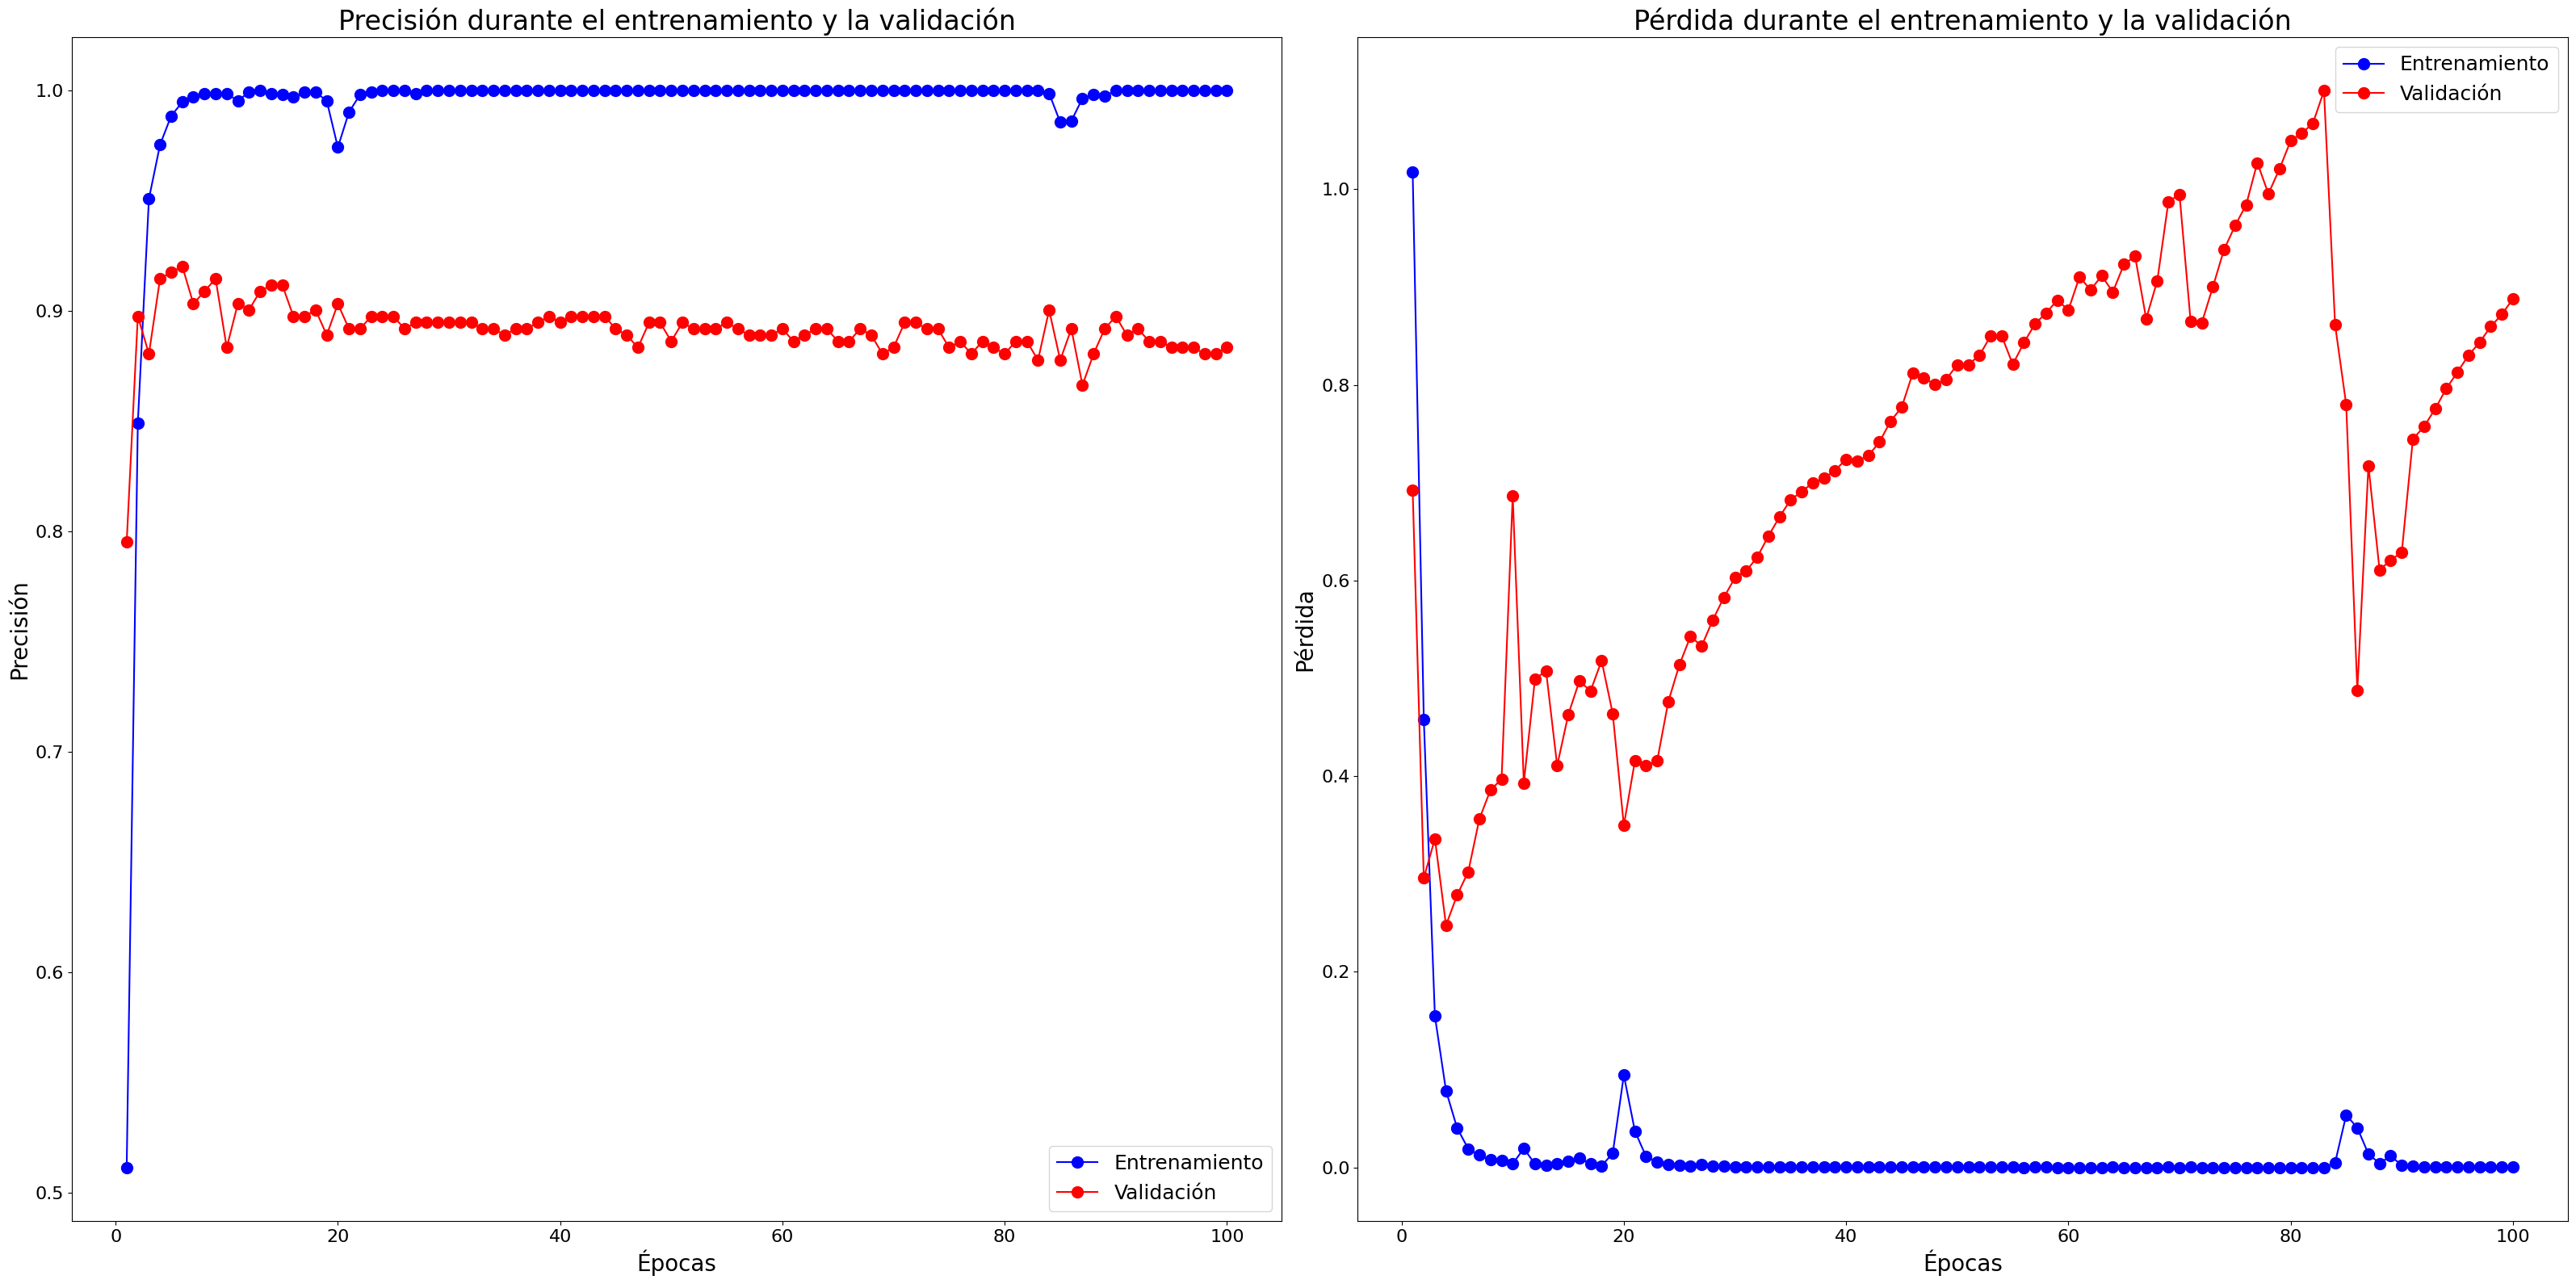

In [27]:
import matplotlib.pyplot as plt

# Obtener los datos del historial
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(32, 16))  

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Entrenamiento', markersize=10) 
plt.plot(epochs, val_acc, 'ro-', label='Validación', markersize=10) 
plt.title('Precisión durante el entrenamiento y la validación', fontsize=24)  
plt.xlabel('Épocas', fontsize=20) 
plt.ylabel('Precisión', fontsize=20)  
plt.legend(fontsize=18)  
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  

# Graficar la pérdida en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Entrenamiento', markersize=10)  
plt.plot(epochs, val_loss, 'ro-', label='Validación', markersize=10) 
plt.title('Pérdida durante el entrenamiento y la validación', fontsize=24)  
plt.xlabel('Épocas', fontsize=20) 
plt.ylabel('Pérdida', fontsize=20)  
plt.legend(fontsize=18) 
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  

plt.tight_layout()  
plt.show()


## ✅ Final Evaluation and Insights

After evaluating the model on the test set, we obtained an accuracy of **83.4%**.

This is a solid result considering that the model was trained with a relatively small dataset (~700 samples per class).  
As previously mentioned, having a **large and diverse dataset** is essential for allowing the model to **generalize well**. Even with a well-designed architecture and reasonable hyperparameters, limited training data can restrict the overall performance.

One possible improvement would be to apply **Transfer Learning**, using a model that has already been trained on a large corpus of text for sentiment analysis or general language understanding. This approach would allow the model to start from a much richer understanding of language, which could significantly enhance its performance on this specific task.

> 🎯 In real-world applications, combining a well-designed architecture with transfer learning and sufficient training data is often the key to achieving state-of-the-art results.


In [28]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


8/8 - 0s - loss: 1.1605 - accuracy: 0.8340 - 110ms/epoch - 14ms/step
Test Loss: 1.1605106592178345
Test Accuracy: 0.8340425491333008


In [29]:
import numpy as np

loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

predictions = model.predict(X_test)


predicted_indices = np.argmax(predictions, axis=1)


label_map = {
    0: "Negativo",
    1: "Neutro",
    2: "Positivo"
}

predicted_sentiments = [label_map[i] for i in predicted_indices]

for i in range(100):
    print("Comentario:", test_df.iloc[i]["comentario"])
    print("Sentimiento predicho:", predicted_sentiments[i])
    print("Probabilidades:", predictions[i])
    print("-" * 50)


8/8 - 0s - loss: 1.1605 - accuracy: 0.8340 - 109ms/epoch - 14ms/step
Test Loss: 1.1605106592178345
Test Accuracy: 0.8340425491333008
Comentario: La atención del personal fue impecable y muy amable
Sentimiento predicho: Positivo
Probabilidades: [1.1688391e-07 1.6859725e-06 9.9999821e-01]
--------------------------------------------------
Comentario: La comida era aceptable sin nada especial
Sentimiento predicho: Neutro
Probabilidades: [7.779687e-08 9.999989e-01 9.232782e-07]
--------------------------------------------------
Comentario: Me agradó la rapidez con la que se procesó el pago
Sentimiento predicho: Positivo
Probabilidades: [3.7093176e-07 3.0413460e-06 9.9999654e-01]
--------------------------------------------------
Comentario: Superó mis expectativas en cuanto a durabilidad
Sentimiento predicho: Positivo
Probabilidades: [2.2824281e-06 3.5230651e-06 9.9999416e-01]
--------------------------------------------------
Comentario: El producto defectuoso no fue reemplazado a pesar d

## 💾 Saving the Model for Deployment

After training and evaluating the model, we save it so that it can be reused in our **Flask web application**.

This step is crucial because it allows us to deploy the model without retraining it every time.  
We also save the `Tokenizer` object, which is necessary to preprocess user input in the exact same way as during training.

Both the model and the tokenizer will be loaded in the backend of the chatbot, allowing real-time sentiment predictions.

```python
# Save the model
model.save("best_model.h5")

# Save the tokenizer
with open("modeltokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [30]:
model.save("modelChatBot.h5")